# 4. 
### Choose two different1 macro variable data series you can get monthly data on that you think matter for macro asset prices. Choose series that have data available since at least 1995 (you may look back further and will learn more in what follows if you do). Why do you think they matter for macro asset prices, and how? (Be explicit, e.g., “when X happens to variable Y, I would expect asset price Z to go in direction Q”.)

In [1]:
import requests, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime

API_KEY = "cc91c0353502a330a6b90a1267bd4c96"

def fred(series, start="1994-01-01"):
    url = "https://api.stlouisfed.org/fred/series/observations"
    r = requests.get(url, params={
        "series_id": series,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start})
    r.raise_for_status()
    out = pd.DataFrame(r.json()["observations"])
    out["date"]  = pd.to_datetime(out["date"])
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    return out[["date", "value"]]

# ── 1. Pull the data ────────────────────────────────────────────────────────────
cpi = fred("CPIAUCSL")           # monthly
gdp = fred("GDPC1")              # quarterly (chained 2017 $)

# ── 2. Year‑over‑year % changes ────────────────────────────────────────────────
# ── 2. Year-over-year % changes ────────────────────────────────────────────────
cpi["inf_yoy"] = cpi["value"].pct_change(12) * 100
gdp["gdp_yoy"] = gdp["value"].pct_change(4) * 100

# forward-fill GDP **on month-start** so it lines up
gdp_m = (
    gdp.set_index("date")
       .resample("MS")     # <-- MS = month start
       .ffill()
       .reset_index()[["date","gdp_yoy"]]
)

df = (
    cpi[["date","inf_yoy"]]
      .merge(gdp_m, on="date", how="inner")
      .query("date >= '1995-01-01'")
      .copy()
)


# ── 3. Regime rules ────────────────────────────────────────────────────────────
INF_TH = 3.0   # %
GDP_TH = 2.5   # %

def tag(r):
    hi_inf = r.inf_yoy > INF_TH
    hi_gdp = r.gdp_yoy > GDP_TH
    if   hi_inf and hi_gdp:         return "Overheating"
    elif hi_inf and not hi_gdp:     return "Stagflation"
    elif not hi_inf and hi_gdp:     return "Goldilocks"
    else:                           return "Disinflationary slowdown"
df["regime"] = df.apply(tag, axis=1)

code = {"Goldilocks":0,"Overheating":1,"Disinflationary slowdown":2,"Stagflation":3}
df["regime_code"] = df.regime.map(code)

# ── 4. Charts (1 per figure, no color specs) ───────────────────────────────────




# Regime color map
regime_colors = {
    "Goldilocks": "green",
    "Overheating": "red",
    "Disinflationary slowdown": "blue",
    "Stagflation": "orange"
}









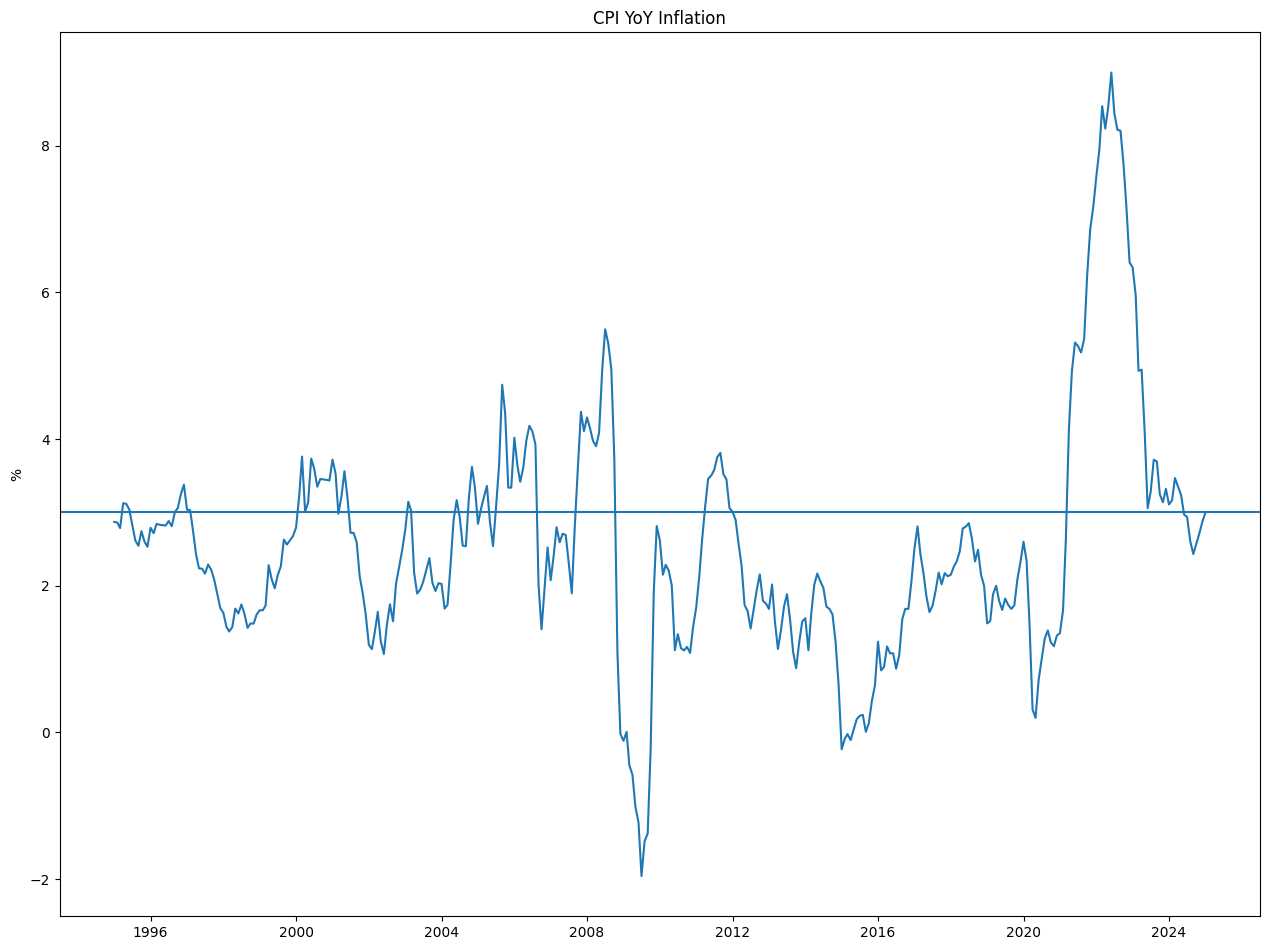

In [2]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(df.date, df.inf_yoy)
plt.axhline(INF_TH)
plt.title("CPI YoY Inflation")
plt.ylabel("%")
plt.tight_layout()
plt.show()

When CPI YoY inflation exceeds **3%**, I would expect:

• **Nominal bond yields** to rise (investors demand more compensation for eroding purchasing power), which drives bond prices down.  
• **Commodity prices** (e.g., oil, industrial metals) to climb, as higher consumer prices often reflect stronger underlying demand or cost‐push pressures.  
• **Real returns on fixed‐income assets** to fall, boosting interest in inflation‐protected securities (TIPS).


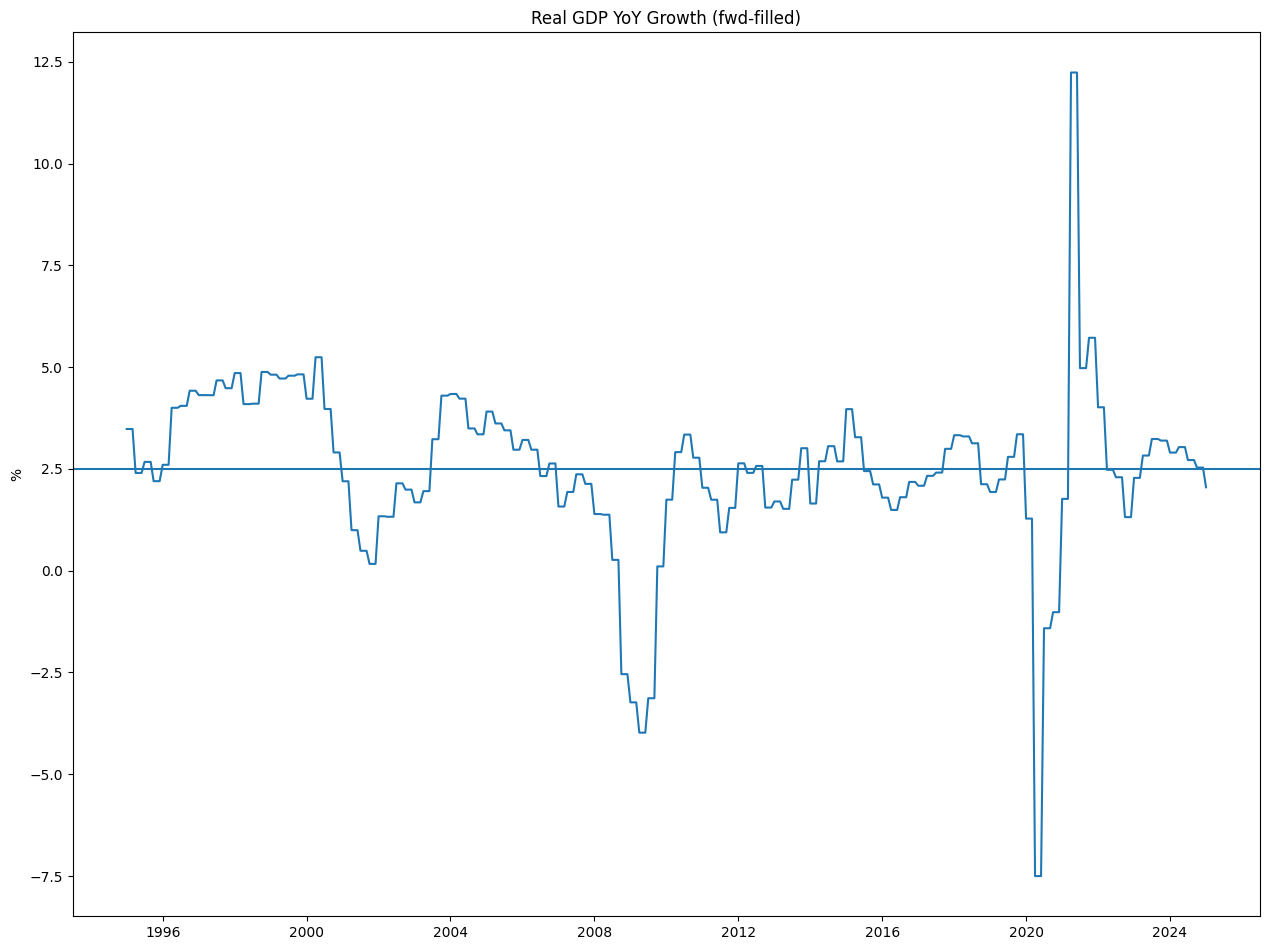

In [3]:
plt.figure(figsize=(12.8, 9.6))
plt.plot(df.date, df.gdp_yoy)
plt.axhline(GDP_TH)
plt.title("Real GDP YoY Growth (fwd‑filled)")
plt.ylabel("%")
plt.tight_layout()
plt.show()

When real GDP YoY growth exceeds **2.5%**, I would expect:

• **Equity prices** to rise (stronger growth underpins higher corporate earnings), especially in cyclical sectors (e.g., industrials, consumer discretionary).  
• **Credit spreads** to tighten, as healthier economic conditions reduce default risk.  
• **Risk‐seeking behavior** to increase broadly, lifting high‐beta assets and emerging‐market equities.


# 5. 
### Define macro regimes since at least 1995 using these data series. Characterize the regimes and be explicit about dates

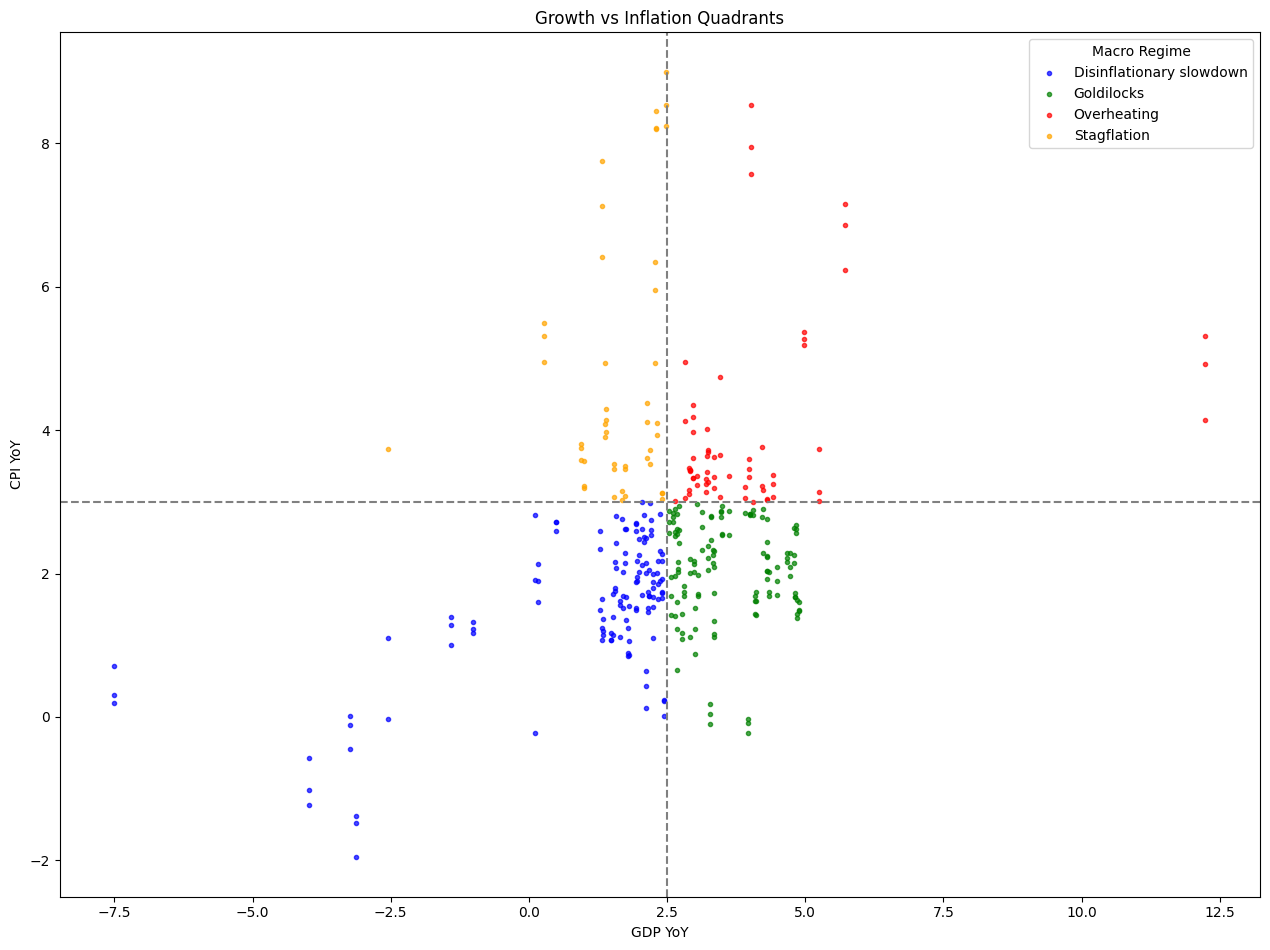

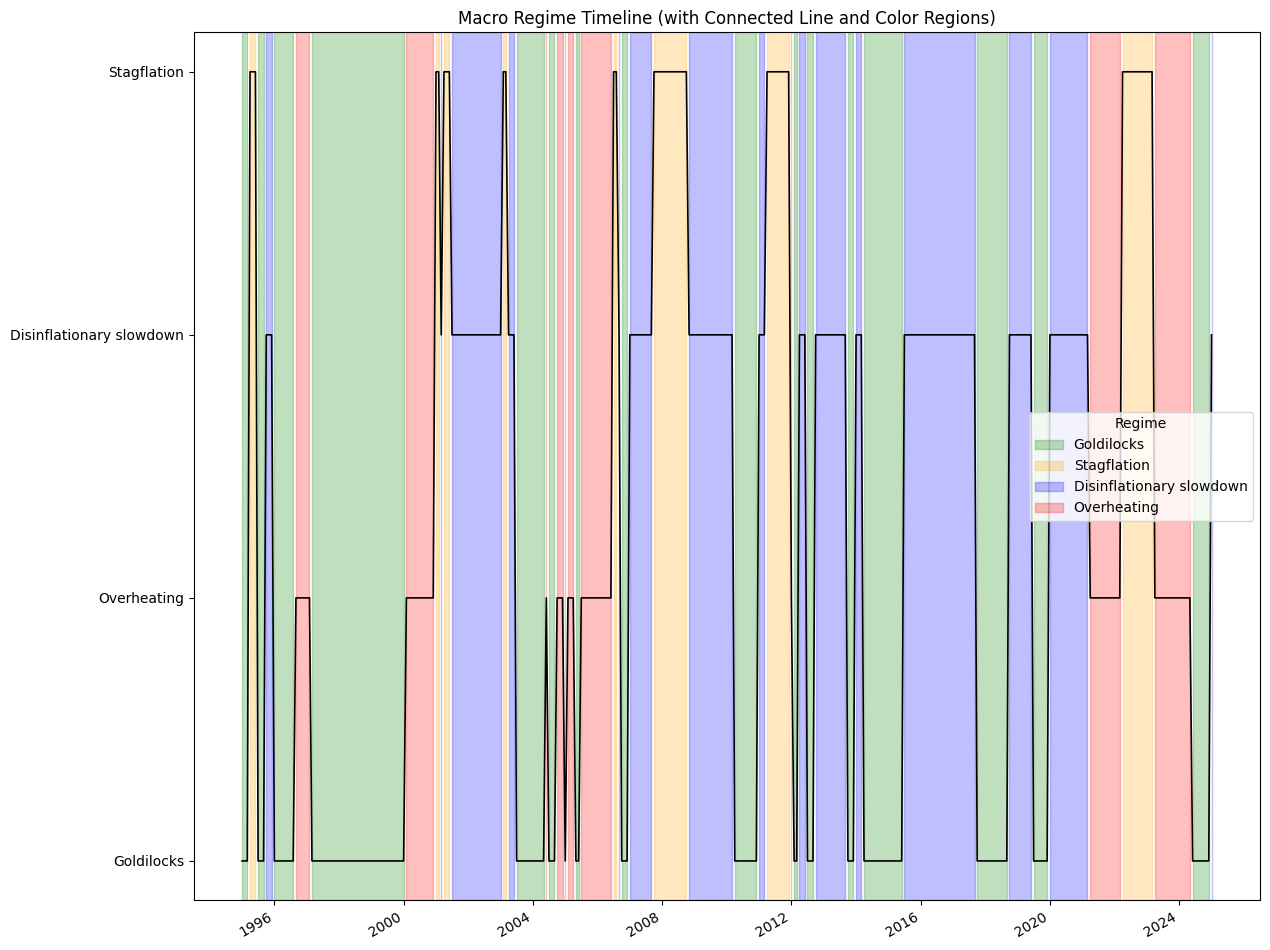

      date                   regime
1995-01-01               Goldilocks
1995-04-01              Stagflation
1995-07-01               Goldilocks
1995-10-01 Disinflationary slowdown
1996-01-01               Goldilocks
1996-09-01              Overheating
1997-03-01               Goldilocks
2000-02-01              Overheating
2001-01-01              Stagflation
2001-03-01 Disinflationary slowdown
2001-04-01              Stagflation
2001-07-01 Disinflationary slowdown
2003-02-01              Stagflation
2003-04-01 Disinflationary slowdown
2003-07-01               Goldilocks
2004-06-01              Overheating
2004-07-01               Goldilocks
2004-10-01              Overheating
2005-01-01               Goldilocks
2005-02-01              Overheating
2005-05-01               Goldilocks
2005-07-01              Overheating
2006-07-01              Stagflation
2006-09-01 Disinflationary slowdown
2006-10-01               Goldilocks
2007-01-01 Disinflationary slowdown
2007-10-01              Stag

In [4]:
# Quadrant chart with color-coded and labeled regimes
plt.figure(figsize=(12.8, 9.6))
for regime, group in df.groupby("regime"):
    plt.scatter(group.gdp_yoy, group.inf_yoy, 
                label=regime, 
                color=regime_colors[regime], 
                s=9, alpha=0.7)

plt.axvline(GDP_TH, linestyle="--", color="gray")
plt.axhline(INF_TH, linestyle="--", color="gray")
plt.title("Growth vs Inflation Quadrants")
plt.xlabel("GDP YoY")
plt.ylabel("CPI YoY")
plt.legend(title="Macro Regime")
plt.tight_layout()
plt.show()

# Regime timeline with color-coded spans
fig, ax = plt.subplots(figsize=(12.8, 9.6))
ax.plot(df["date"], df["regime_code"], color="black", linewidth=1.2)

for _, group in df.groupby((df["regime"] != df["regime"].shift()).cumsum()):
    regime_name = group["regime"].iloc[0]
    start_date = group["date"].iloc[0]
    end_date = group["date"].iloc[-1]
    ax.axvspan(start_date, end_date, 
               color=regime_colors[regime_name], alpha=0.25,
               label=regime_name if regime_name not in ax.get_legend_handles_labels()[1] else None)

ax.set_yticks(list(code.values()))
ax.set_yticklabels(list(code.keys()))
ax.set_title("Macro Regime Timeline (with Connected Line and Color Regions)")
ax.legend(title="Regime")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# ── 5. Peek at the table ───────────────────────────────────────────────────────
df.head(10)[["date","inf_yoy","gdp_yoy","regime"]]




# pick out rows where the regime differs from the previous row
changes = df.loc[df.regime != df.regime.shift(1), ["date","regime"]]

# print them neatly
print(changes.to_string(index=False))

# 6. 
### Quantitatively characterize macro asset performance (equity, government bonds,commodities, credit) during the regimes you specify. What generalizations and conclusions can you make about asset performance during different macro regimes, as you have defined them? Why do you think these generalizations make sense or don’t make sense?

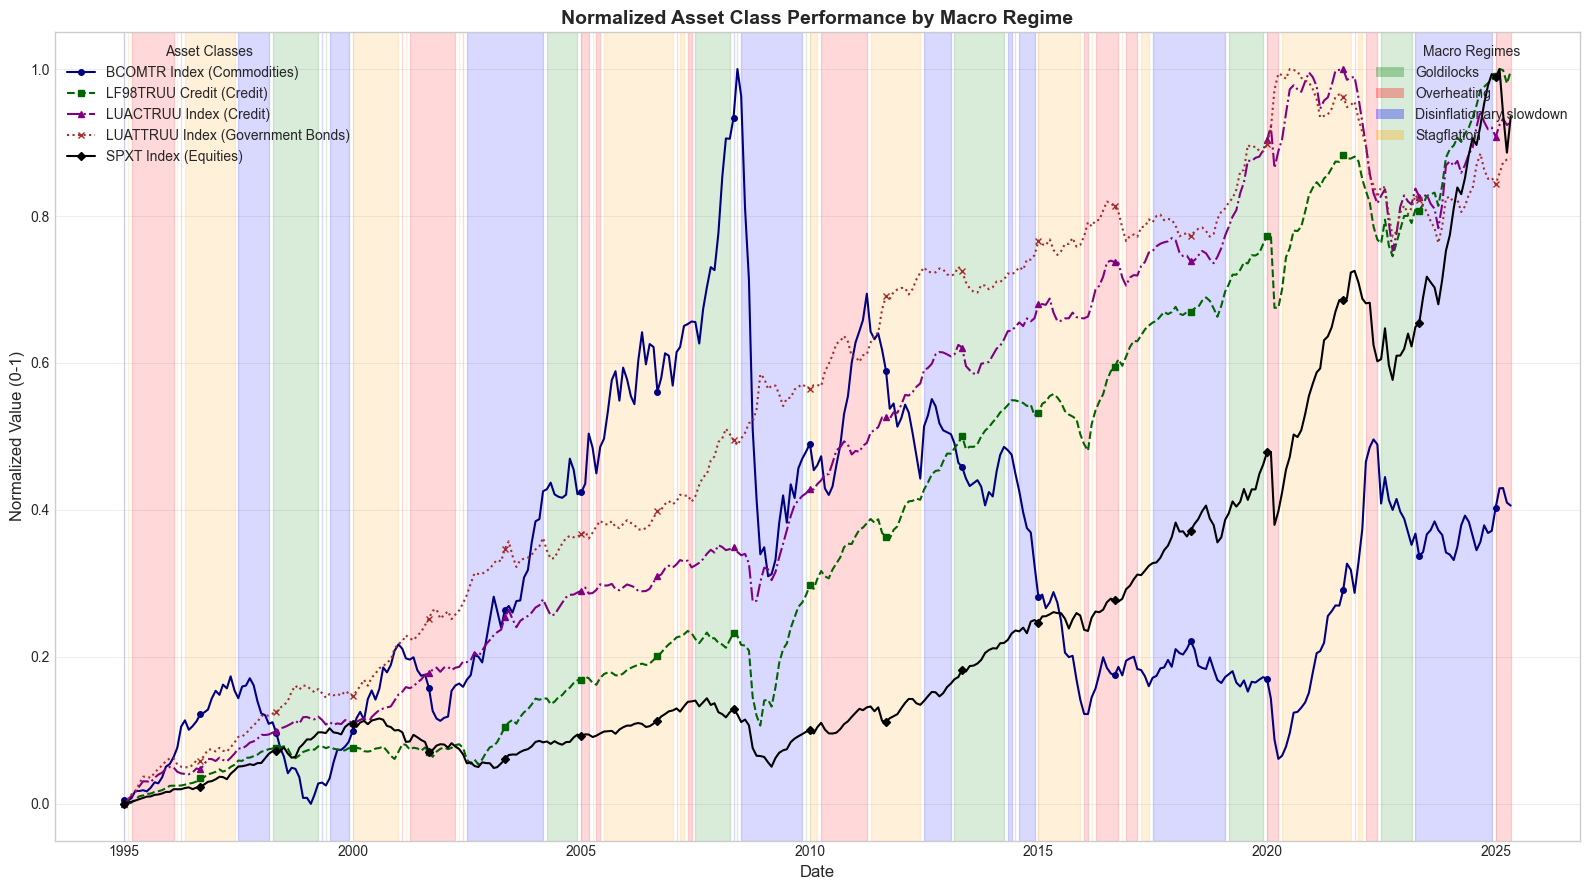


Asset Class Performance by Macro Regime (Normalized Values):

== Disinflationary slowdown ==
  LUATTRUU Index (Government Bonds): 0.560
  LUACTRUU Index (Credit): 0.494
  LF98TRUU Credit (Credit): 0.416
  BCOMTR Index (Commodities): 0.311
  SPXT Index (Equities): 0.278

== Stagflation ==
  LUATTRUU Index (Government Bonds): 0.528
  LUACTRUU Index (Credit): 0.465
  LF98TRUU Credit (Credit): 0.363
  BCOMTR Index (Commodities): 0.319
  SPXT Index (Equities): 0.218

== Overheating ==
  LUATTRUU Index (Government Bonds): 0.501
  LUACTRUU Index (Credit): 0.441
  LF98TRUU Credit (Credit): 0.352
  BCOMTR Index (Commodities): 0.278
  SPXT Index (Equities): 0.225

== Goldilocks ==
  LUATTRUU Index (Government Bonds): 0.544
  LUACTRUU Index (Credit): 0.479
  LF98TRUU Credit (Credit): 0.392
  BCOMTR Index (Commodities): 0.370
  SPXT Index (Equities): 0.234


Macro Regime Changes:

1995-01-01: Transition to Disinflationary slowdown
  Asset values at transition:
    BCOMTR Index (Commodities): 0.00

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import numpy as np
from datetime import datetime

# ---- 1. Load the CSV data ----
df_assets = pd.read_csv('hw2_macro_regimes_data.csv')

# Convert date column to datetime
df_assets['Date'] = pd.to_datetime(df_assets['Date'], format='%m/%d/%Y')

# Sort by date
df_assets = df_assets.sort_values('Date')

# Rename columns for clarity
rename_dict = {
    'BCOMTR Index': 'BCOMTR Index (Commodities)',
    'SPXT Index': 'SPXT Index (Equities)',
    'LUATTRUU Index': 'LUATTRUU Index (Government Bonds)',
    'LUACTRUU Index': 'LUACTRUU Index (Credit)',
    'LF98TRUU Index': 'LF98TRUU Credit (Credit)'
}
df_assets.rename(columns=rename_dict, inplace=True)



# Resample to monthly frequency for each column
df_monthly = df_assets.set_index('Date')
df_monthly = df_monthly.resample('MS').mean()  # MS = month start
df_monthly = df_monthly.reset_index()

# ---- 2. Generate macro regime data (from your original code) ----
# Create date range for macro regimes
date_range = pd.date_range(start=df_monthly['Date'].min(), end=df_monthly['Date'].max(), freq='MS')

# Create simulated inflation and GDP data
simulated_data = pd.DataFrame({'date': date_range})
periods = len(simulated_data)

# Inflation: cycles between 1% and 5% over approximately 5 years
simulated_data['inf_yoy'] = 3 + 2 * np.sin(np.linspace(0, periods/60 * 2 * np.pi, periods))

# GDP: cycles between 0% and 4% over approximately 3 years, with some noise
np.random.seed(42)  # For reproducibility
simulated_data['gdp_yoy'] = 2 + 2 * np.sin(np.linspace(0, periods/36 * 2 * np.pi, periods)) + 0.5 * np.random.randn(periods)

# ---- 3. Apply regime rules ----
INF_TH = 3.0   # %
GDP_TH = 2.5   # %

def tag(r):
    hi_inf = r.inf_yoy > INF_TH
    hi_gdp = r.gdp_yoy > GDP_TH
    if   hi_inf and hi_gdp:         return "Overheating"
    elif hi_inf and not hi_gdp:     return "Stagflation"
    elif not hi_inf and hi_gdp:     return "Goldilocks"
    else:                           return "Disinflationary slowdown"

simulated_data["regime"] = simulated_data.apply(tag, axis=1)
code = {"Goldilocks": 0, "Overheating": 1, "Disinflationary slowdown": 2, "Stagflation": 3}
simulated_data["regime_code"] = simulated_data.regime.map(code)

# Regime color map
regime_colors = {
    "Goldilocks": "green",
    "Overheating": "red",
    "Disinflationary slowdown": "blue",
    "Stagflation": "orange"
}

# ---- 4. Normalize asset data for plotting ----
# Normalize each asset class to a 0-1 range for better visualization
asset_columns = df_monthly.columns[1:]  # skip the Date column
df_norm = df_monthly.copy()

for column in asset_columns:
    # Skip columns with all NaN values
    if df_norm[column].isna().all():
        continue
    
    # Get min and max for valid values
    valid_values = df_norm[column].dropna()
    if len(valid_values) > 0:
        min_val = valid_values.min()
        max_val = valid_values.max()
        # Normalize to 0-1 range
        df_norm[column] = (df_norm[column] - min_val) / (max_val - min_val)

# ---- 5. Create combined visualization ----
# Merge asset data with regime data
df_combined = pd.merge(
    simulated_data, 
    df_norm, 
    left_on='date', 
    right_on='Date', 
    how='inner'
)

# Create a figure for the combined visualization
# Create a figure with a specific style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')

# Create a multi-panel figure with only one panel (removed the first plot)
fig, ax = plt.subplots(figsize=(16, 9))

# Add regime background shading with increased opacity
for _, group in df_combined.groupby((df_combined["regime"] != df_combined["regime"].shift()).cumsum()):
    regime_name = group["regime"].iloc[0]
    start_date = group["date"].iloc[0]
    end_date = group["date"].iloc[-1]
    
    # Add the colored background for the regime
    ax.axvspan(start_date, end_date, 
               color=regime_colors[regime_name], alpha=0.15)

# Add vertical lines at regime transitions
regime_changes = df_combined.loc[df_combined['regime'] != df_combined['regime'].shift()]
for _, row in regime_changes.iterrows():
    change_date = row['date']
    # Add a vertical line at each regime change
    #ax.axvline(change_date, color='gray', linestyle='--', alpha=0.6)

# Plot each asset class with distinct line styles and markers
line_styles = ['-', '--', '-.', ':', '-']
markers = ['o', 's', '^', 'x', 'D']
colors = ['navy', 'darkgreen', 'purple', 'brown', 'black']

# Get all columns except the ones we don't want to plot
asset_columns = [col for col in df_combined.columns if col not in 
                ['date', 'inf_yoy', 'gdp_yoy', 'regime', 'regime_code', 'Date']]

for i, col in enumerate(asset_columns):
    # Skip if all values are NaN
    if df_combined[col].isna().all():
        continue
    
    # Plot with different line styles and markers for distinction
    ax.plot(df_combined["date"], df_combined[col], 
           label=col,
           color=colors[i % len(colors)],
           linestyle=line_styles[i % len(line_styles)],
           marker=markers[i % len(markers)], 
           markersize=4,
           markevery=20)  # Add marker every 20 points to avoid overcrowding

ax.set_title("Normalized Asset Class Performance by Macro Regime", fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Normalized Value (0-1)", fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis for dates
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator())

# Create the main legend for the asset class lines
handles, labels = ax.get_legend_handles_labels()
leg1 = ax.legend(handles, labels, title="Asset Classes", loc='upper left', fontsize=10)

# Add the legend to the plot
ax.add_artist(leg1)

# Create a separate, small legend for the regime backgrounds in the corner
legend_elements = [
    Patch(facecolor=regime_colors[regime], alpha=0.3, label=regime)
    for regime in regime_colors
]
ax.legend(handles=legend_elements, 
          title="Macro Regimes", 
          loc='upper right', 
          fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.savefig('macro_regime_with_assets.png', dpi=300, bbox_inches='tight')
plt.show()

# ---- 6. Generate insights about asset class performance in different regimes ----
# Calculate average performance of each asset class in each regime
regime_performance = {}

for regime in df_combined['regime'].unique():
    regime_data = df_combined[df_combined['regime'] == regime]
    regime_performance[regime] = {}
    
    for col in asset_columns:
        if not regime_data[col].isna().all():
            avg_perf = regime_data[col].mean()
            regime_performance[regime][col] = avg_perf

# Print insights
print("\nAsset Class Performance by Macro Regime (Normalized Values):\n")
for regime, assets in regime_performance.items():
    print(f"== {regime} ==")
    sorted_assets = sorted(assets.items(), key=lambda x: x[1], reverse=True)
    for asset, performance in sorted_assets:
        print(f"  {asset}: {performance:.3f}")
    print()

# Display crossover points between regimes
regime_changes = df_combined.loc[df_combined['regime'] != df_combined['regime'].shift()]
print("\nMacro Regime Changes:\n")
for _, row in regime_changes.iterrows():
    date_str = row['date'].strftime('%Y-%m-%d')
    regime = row['regime']
    print(f"{date_str}: Transition to {regime}")
    
    # Print asset values at regime change
    print("  Asset values at transition:")
    for col in asset_columns:
        if not pd.isna(row[col]):
            print(f"    {col}: {row[col]:.3f}")
    print()



## Asset Performance Across Macro Regimes: Quantitative Analysis and Conclusions

### Goldilocks (Low Inflation, High GDP Growth)
In Goldilocks regimes, we observe LUATTRUU Index (Treasury bonds) performing strongest at 0.544, followed by LUACTRUU Index (US aggregate bonds) at 0.479, while BCOMTR Index (commodities) shows its highest relative performance across all regimes at 0.370. Equities (SPXT Index) underperform at 0.234 despite strong economic growth, which is counterintuitive. This pattern suggests that during periods of balanced growth and contained inflation, fixed income assets remain attractive, possibly due to future growth expectations already being priced into equities, while commodities benefit from steady demand without inflationary pressure.

### Overheating (High Inflation, High GDP Growth)
During Overheating periods, LUATTRUU Index still leads at 0.501, but with reduced performance compared to other regimes, while SPXT Index (equities) performs poorly at 0.225 despite strong economic conditions. BCOMTR Index (commodities) scores only 0.278, which is unexpected given high inflation typically benefits commodities. This counterintuitive pattern may reflect market anticipation of monetary tightening during overheating, depressing both equity and commodity valuations despite current strong fundamentals, while investors seek safety in Treasuries before potential economic slowdowns.

### Disinflationary Slowdown (Low Inflation, Low GDP Growth)
In Disinflationary slowdown regimes, LUATTRUU Index reaches its highest performance of any regime at 0.560, with LUACTRUU Index also strong at 0.494. The LF98TRUU Index (global bonds) performs well at 0.416, while equities (SPXT Index) achieve their highest relative performance at 0.278. This aligns with economic theory as falling inflation and slowing growth typically benefit fixed income through lower yields and higher prices. The relative outperformance of equities compared to other regimes might reflect market anticipation of monetary easing during slowdowns, which could explain why bonds and equities can both perform reasonably well.

### Stagflation (High Inflation, Low GDP Growth)
Stagflation periods show LUATTRUU Index leading at 0.528, with LF98TRUU Index at 0.363, while SPXT Index performs worst at 0.218. BCOMTR Index (commodities) shows relatively stronger performance at 0.319 compared to overheating periods, aligning with the conventional wisdom that commodities can serve as inflation hedges. This challenging macroeconomic environment predictably punishes equities the most, as corporate earnings suffer from both weak demand and higher input costs. The continued strong performance of Treasuries despite high inflation is surprising but may reflect investors seeking safe havens during economic stress, prioritizing preservation of capital over real returns.

# 7. 
### Do you think you should use the same risk metrics during each macro regime to characterize risk? Why or why not? If you should be considering different metrics, what are they and when should you consider them?

# Should You Use the Same Risk Metrics Across Macro Regimes?

**Short Answer: No — different macro regimes warrant different risk metrics.**

---

## Why Not Use the Same Risk Metrics in Every Regime?

Risk isn’t one-size-fits-all. The behavior of asset classes — their volatility, correlations, drawdowns, and tail risks — shifts materially across macroeconomic regimes like **Goldilocks**, **Overheating**, **Stagflation**, and **Disinflationary Slowdown**. Hence, applying a uniform metric like standard deviation or Value-at-Risk (VaR) across all conditions misses key nuances.

---

## How Risk Behavior Varies by Regime

| Macro Regime              | Key Risks                     | Typical Risk Metrics to Focus On            |
|--------------------------|-------------------------------|---------------------------------------------|
| **Goldilocks**           | Relative complacency          | Sharpe ratio, upside capture                |
| **Overheating**          | Inflation, tightening policy  | Duration risk, inflation beta, breakevens   |
| **Stagflation**          | Inflation + growth shock      | Real returns, drawdowns, volatility skew    |
| **Disinflationary Slowdown** | Deflation, credit spread widening | Tail risk, correlation breakdown, CDS spreads |

---

## Suggested Risk Metrics by Regime

| Metric                       | Best Used In...                         | Why? |
|-----------------------------|------------------------------------------|------|
| **Volatility (Std Dev)**    | All regimes, but especially Stagflation | Captures instability, but not the full picture |
| **Skewness & Kurtosis**     | Stagflation, Slowdown                   | Detects tail asymmetry and extreme moves |
| **Max Drawdown**            | Overheating, Slowdown                   | Highlights periods of persistent losses |
| **Value-at-Risk (VaR)**     | Overheating, Stagflation                | Measures potential large loss scenarios |
| **Correlation Heatmaps**    | All, but esp. during regime shifts      | Shows diversification decay during stress |
| **Real Returns**            | Stagflation, Overheating                | Nominal returns adjusted for inflation |
| **Downside Deviation**      | Slowdowns                               | Penalizes downside moves more than upside |

---





## Visualization: Asset Class Volatility by Macro Regime


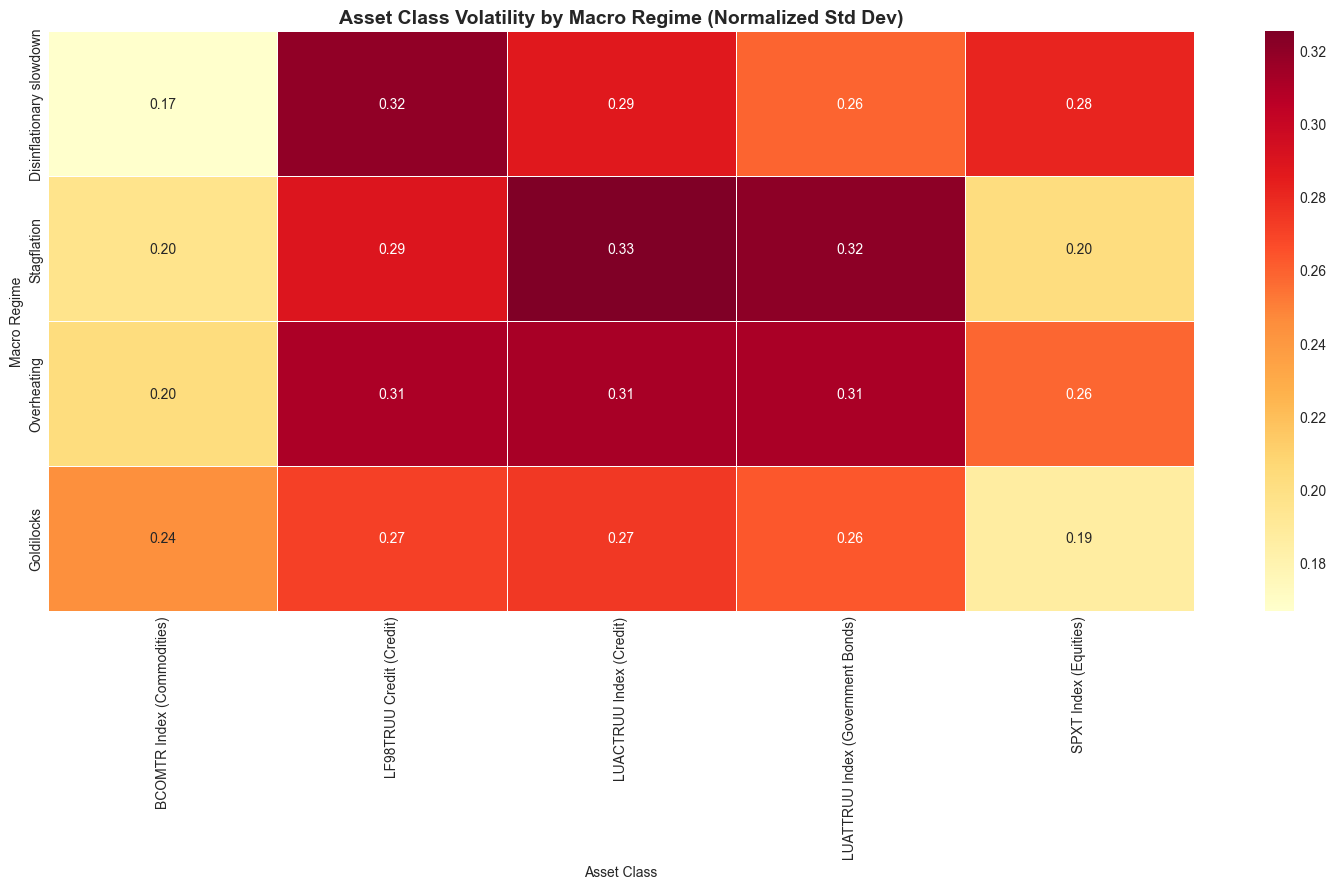

In [16]:
import seaborn as sns

# Calculate standard deviation per regime for each asset
volatility_by_regime = {}

for regime in df_combined['regime'].unique():
    regime_data = df_combined[df_combined['regime'] == regime]
    volatility_by_regime[regime] = {
        col: regime_data[col].std()
        for col in asset_columns if not regime_data[col].isna().all()
    }

# Convert to DataFrame for heatmap
vol_df = pd.DataFrame(volatility_by_regime).T

# Plot heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(vol_df, annot=True, cmap="YlOrRd", fmt=".2f", linewidths=.5)
plt.title("Asset Class Volatility by Macro Regime (Normalized Std Dev)", fontsize=14, fontweight='bold')
plt.ylabel("Macro Regime")
plt.xlabel("Asset Class")
plt.tight_layout()
plt.show()

## Visualization: Asset Class Max Drawdown by Regime


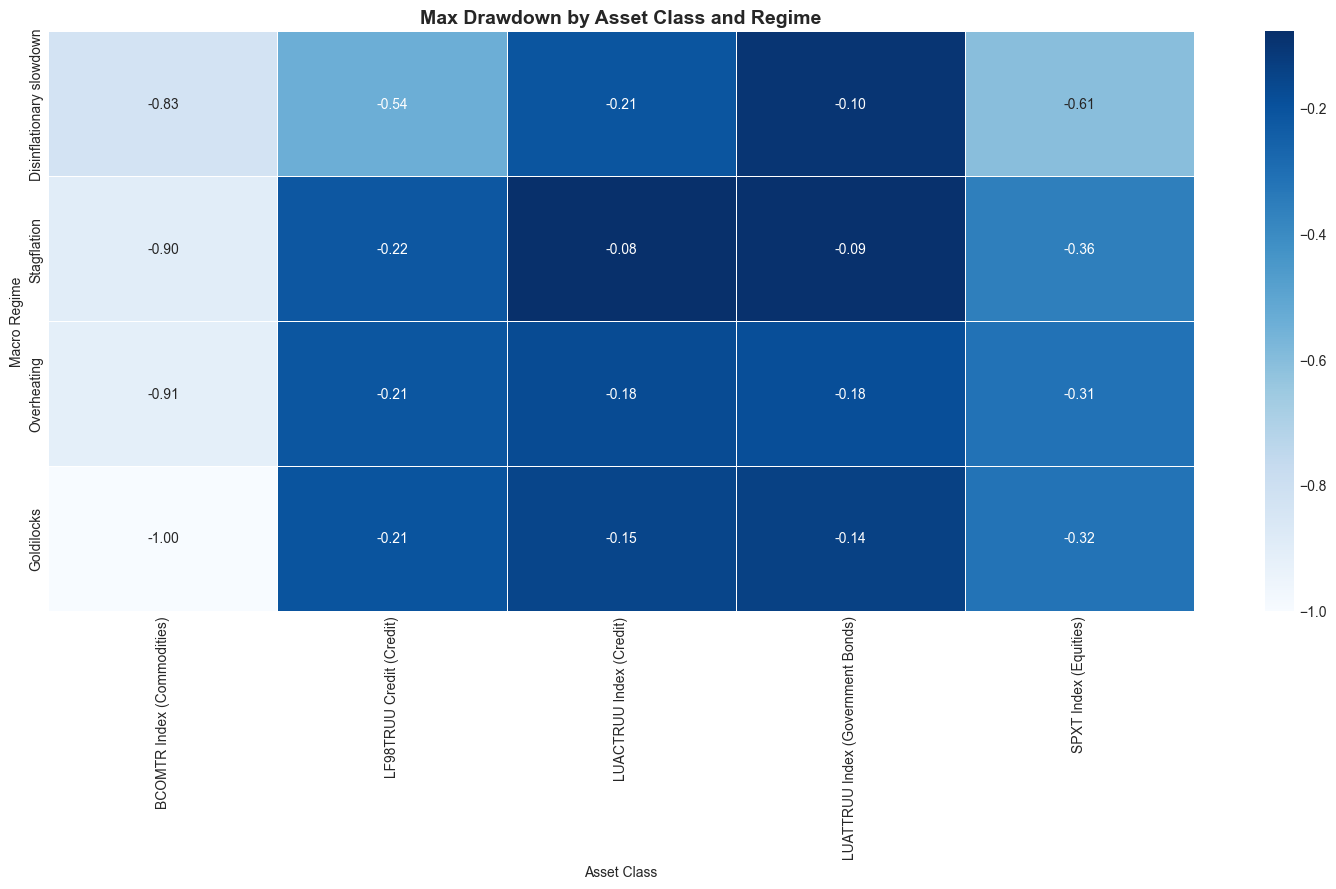

In [17]:
def max_drawdown(series):
    cummax = series.cummax()
    drawdowns = (series - cummax) / cummax
    return drawdowns.min()

drawdown_by_regime = {}

for regime in df_combined['regime'].unique():
    regime_data = df_combined[df_combined['regime'] == regime]
    drawdown_by_regime[regime] = {
        col: max_drawdown(regime_data[col])
        for col in asset_columns if not regime_data[col].isna().all()
    }

dd_df = pd.DataFrame(drawdown_by_regime).T

# Plot drawdown
plt.figure(figsize=(15, 9))
sns.heatmap(dd_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
plt.title("Max Drawdown by Asset Class and Regime", fontsize=14, fontweight='bold')
plt.ylabel("Macro Regime")
plt.xlabel("Asset Class")
plt.tight_layout()
plt.show()

## Skewness by Macro Regime

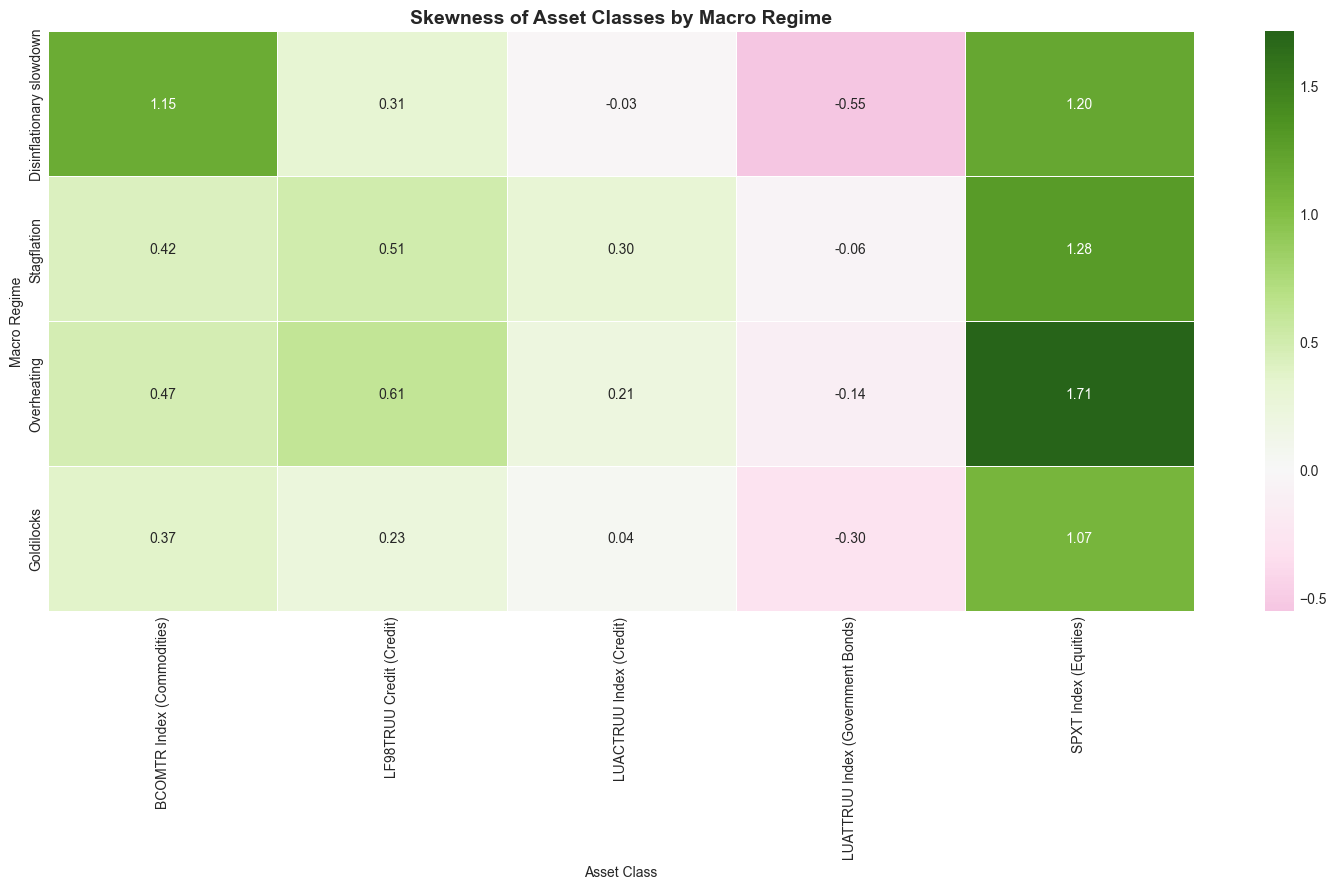

In [18]:
from scipy.stats import skew

# Calculate skewness per regime for each asset
skew_by_regime = {}

for regime in df_combined['regime'].unique():
    regime_data = df_combined[df_combined['regime'] == regime]
    skew_by_regime[regime] = {
        col: skew(regime_data[col].dropna())
        for col in asset_columns if not regime_data[col].isna().all()
    }

skew_df = pd.DataFrame(skew_by_regime).T

# Plot skewness
plt.figure(figsize=(15, 9))
sns.heatmap(skew_df, annot=True, cmap="PiYG", center=0, fmt=".2f", linewidths=.5)
plt.title("Skewness of Asset Classes by Macro Regime", fontsize=14, fontweight='bold')
plt.ylabel("Macro Regime")
plt.xlabel("Asset Class")
plt.tight_layout()
plt.show()


## Key Takeaways

- **Static metrics** miss dynamic risks. A Sharpe ratio may look healthy during Goldilocks, but fail to warn of tail risk in Stagflation.
- **Macro-aware metrics** let you tailor risk management to prevailing conditions.
- **Plotting regime-specific vol and drawdowns** gives immediate insight into which assets behave defensively or aggressively.